# M5 Forecasting Challenge: Predicting Daily Walmart Revenue

**Course:** Advanced Machine Learning - Final Assignment

---

### Project Objective

The goal of this project is to develop a high-performance forecasting model to predict the daily revenue for 10 individual Walmart stores and an aggregate of all stores. The project is inspired by the M5 Forecasting Competition and uses a modified version of its dataset.

Success is measured by the Root Mean Squared Error (RMSE)on a hidden test set, with the primary goal of achieving a lower RMSE than the provided baseline of 11,761 and competing for the top position on the class leaderboard.

### Methodology & Approach

This notebook follows a structured, end-to-end machine learning pipeline to tackle the forecasting problem:

1.  Exploratory Data Analysis (EDA)
2.  Validation Strategy
3.  Feature Engineering
4.  Modeling
5.  Hyperparameter Tuning
6.  Final Forecasting & Submission
---

#### **Set Env**

*   Drive mount
*   Import data
*   Main Vars




In [ ]:
# Cell 1: Setup and Data Loading
from google.colab import drive
drive.mount('/content/drive')

# Define path to your data on Google Drive
DATA_PATH = '/content/drive/MyDrive/M5_Project/'

# Load your data
import pandas as pd
train_df = pd.read_csv(DATA_PATH + 'train.csv')
calendar_df = pd.read_csv(DATA_PATH + 'calendar_events.csv')
sample_submission = pd.read_csv(DATA_PATH + 'forecast_submission.csv')


print("Data loaded successfully!")

Mounted at /content/drive
Data loaded successfully!


In [ ]:
# First, you might need to install Optuna
!pip install optuna -q

import optuna

# General imports
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import os, sys, gc, time, warnings, pickle, psutil, random


from math import ceil

from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 7.6 MB/s eta 0:00:00


In [ ]:
########################### Vars################################################################################
TARGET = 'sales'         # Our main target
END_TRAIN = 1941         # Last day in train set
MAIN_INDEX = ['id','d']  # We can identify item by these columns

##### **Data Merging and Preparation**

We set the data

In [ ]:
## Merging by concat to not lose dtypes
def merge_by_concat(df1, df2, merge_on):
    merged_gf = df1[merge_on]
    merged_gf = merged_gf.merge(df2, on=merge_on, how='left')
    new_columns = [col for col in list(merged_gf) if col not in merge_on]
    df1 = pd.concat([df1, merged_gf[new_columns]], axis=1)
    return df1

In [ ]:
train__stores = train_df[train_df['store_id'] != 0].copy()
print(f"\nRemoved 'All Stores' row. We now have {train__stores['store_id'].nunique()} unique stores.")

# Convert 'date' columns to datetime objects
train_df['date'] = pd.to_datetime(train_df['date'])
train__stores['date'] = pd.to_datetime(train__stores['date'])
calendar_df['date'] = pd.to_datetime(calendar_df['date'])




Removed 'All Stores' row. We now have 10 unique stores.


In [ ]:


# Merge train_df with calendar_df to get all features in one place
df = pd.merge(train__stores, calendar_df, on='date', how='left')
df['event'].fillna(0, inplace=True)

print("\nData merged and cleaned. Here's a sample:")
df.head()


Data merged and cleaned. Here's a sample:


,store_id,store_name,date,revenue,event
0,1,California – Sunset Plaza,2011-01-29,27332.90,0
1,1,California – Sunset Plaza,2011-01-30,24467.65,0
2,1,California – Sunset Plaza,2011-01-31,18003.45,0
3,1,California – Sunset Plaza,2011-02-01,18519.35,0
4,1,California – Sunset Plaza,2011-02-02,16415.30,0


In [ ]:
# --- 3. Establish Validation Framework ---

# Parse the 'id' column in the submission file to find dates
submission_ids = sample_submission['id'].str.split('_', expand=True)
submission_ids.columns = ['store_id_str', 'date_str']
submission_dates = pd.to_datetime(submission_ids['date_str'], format='%Y%m%d')

# The forecast horizon H is the number of unique dates in the submission file
H = submission_dates.nunique()
print(f"The Forecast Horizon (H) is: {H} days.")

# Create the time-based split
last_train_date = df['date'].max()
validation_start_date = last_train_date - pd.to_timedelta(H - 1, unit='D')

train_set = df[df['date'] < validation_start_date].copy()
validation_set = df[df['date'] >= validation_start_date].copy()

print(f"\nTraining data from {train_set['date'].min().date()} to {train_set['date'].max().date()}")
print(f"Validation data from {validation_set['date'].min().date()} to {validation_set['date'].max().date()}")


The Forecast Horizon (H) is: 92 days.

Training data from 2011-01-29 to 2015-06-30
Validation data from 2015-07-01 to 2015-09-30


In [ ]:
print(f"Training set shape: {train_set.shape}")
print(f"Validation set shape: {validation_set.shape}")

Training set shape: (16140, 5)
Validation set shape: (920, 5)


## 1. Exploratory Data Analysis (EDA)

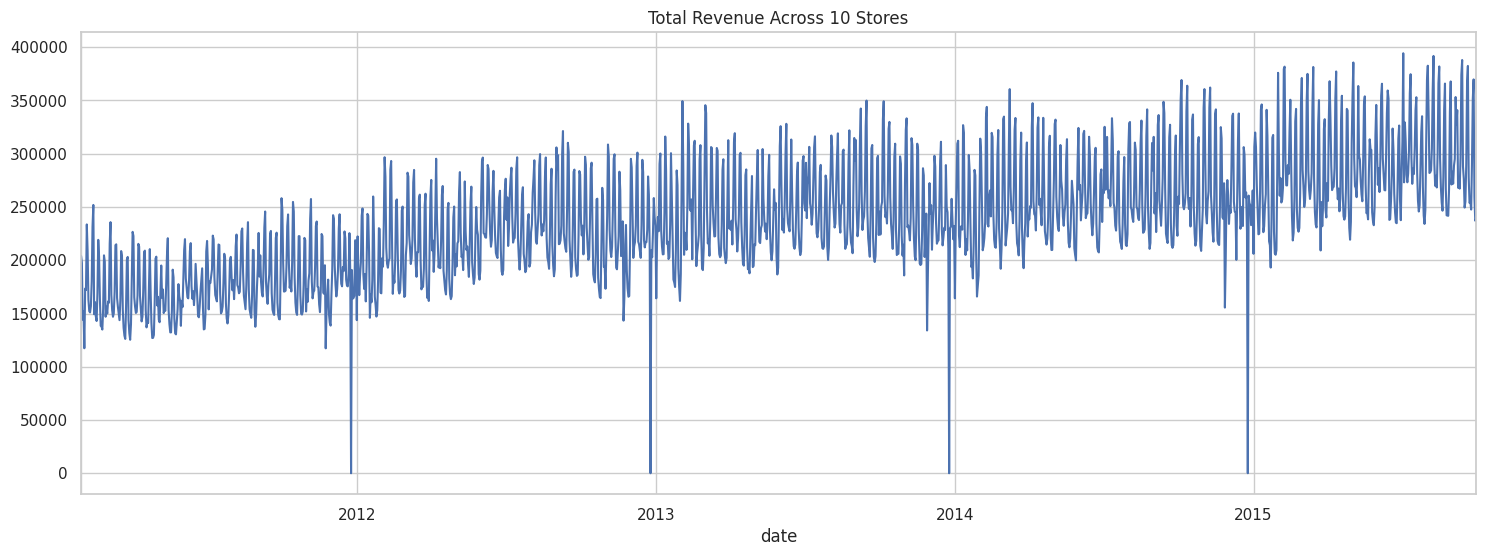

Text(0.5, 1.0, 'Revenue by Day of the Week')

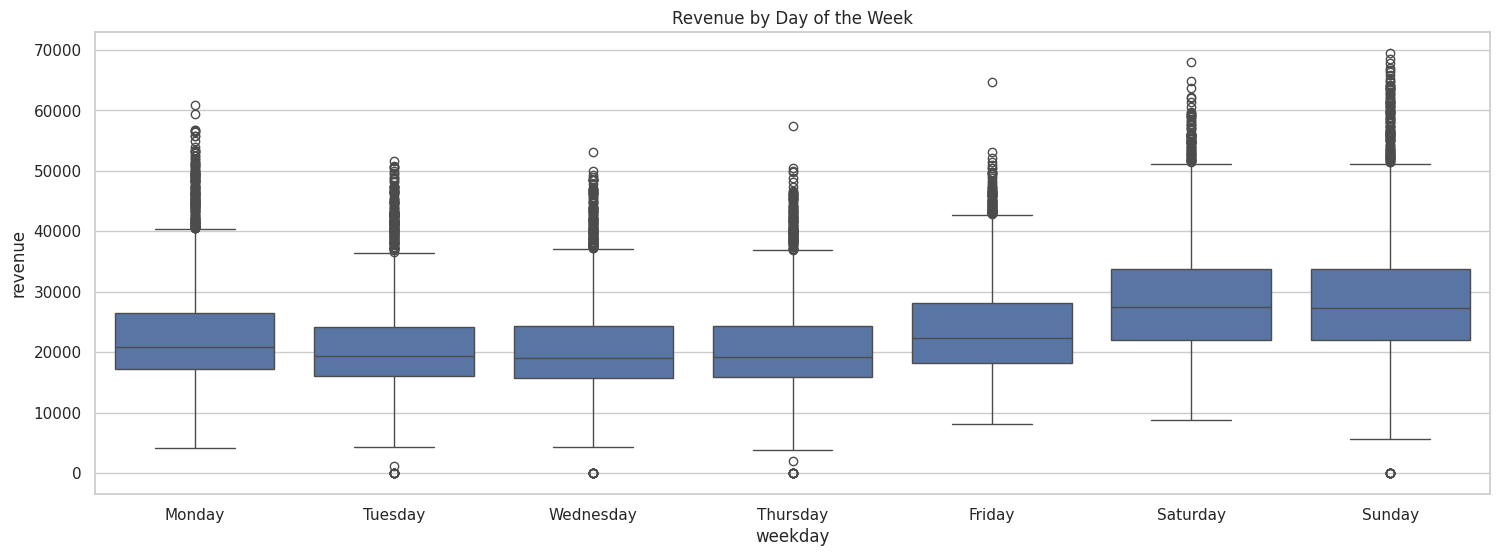

In [ ]:
# --- 4. Exploratory Data Analysis (EDA) ---

# Plot 1: Aggregate Revenue (across the 10 real stores)
df.groupby('date')['revenue'].sum().plot(title='Total Revenue Across 10 Stores')
plt.show()

# Plot 2: Weekly Seasonality
# Before plotting, let's get the weekday name from the date
df['weekday'] = df['date'].dt.day_name()
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
sns.boxplot(data=df, x='weekday', y='revenue', order=day_order)
plt.title('Revenue by Day of the Week')

### 2. Validation Strategy

Evaluate the Seasonal Naive Baseline


In [ ]:
# --- 5. Create and Evaluate the Seasonal Naive Baseline ---

# Sort the full dataset to ensure correct shifting
full_temp = df[['date', 'store_id', 'revenue']].sort_values(['store_id', 'date'])

# Create "last week" prediction by shifting revenue by 7 days *per store*
full_temp['naive_prediction'] = full_temp.groupby('store_id')['revenue'].shift(7)

# Merge predictions onto the validation set
val_with_preds = pd.merge(validation_set[['date', 'store_id', 'revenue']],
                          full_temp[['date', 'store_id', 'naive_prediction']],
                          on=['date', 'store_id'],
                          how='left')

# Drop any rows where the prediction is NaN
val_with_preds.dropna(inplace=True)

# Calculate RMSE
true_values = val_with_preds['revenue']
predicted_values = val_with_preds['naive_prediction']
baseline_rmse = np.sqrt(mean_squared_error(true_values, predicted_values))

print(f"\nProvided Baseline RMSE Target: 11,761")
print(f"Our Seasonal Naive Baseline RMSE: {baseline_rmse:.2f}")

if baseline_rmse < 11761:
    print("\nSuccess! Our simple baseline is already better than the target.")
else:
    print("\nOur simple baseline is not better. This suggests patterns are more complex than just weekly seasonality.")



Provided Baseline RMSE Target: 11,761
Our Seasonal Naive Baseline RMSE: 4324.50

Success! Our simple baseline is already better than the target.


# 3. Feature Engineering

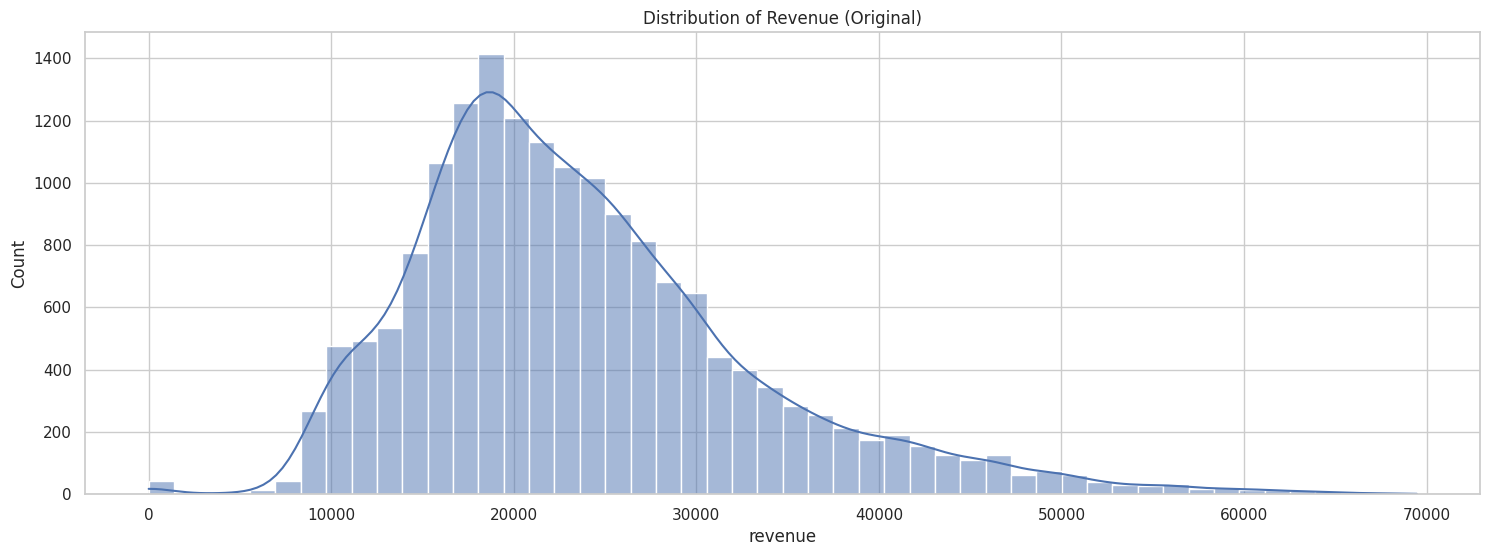

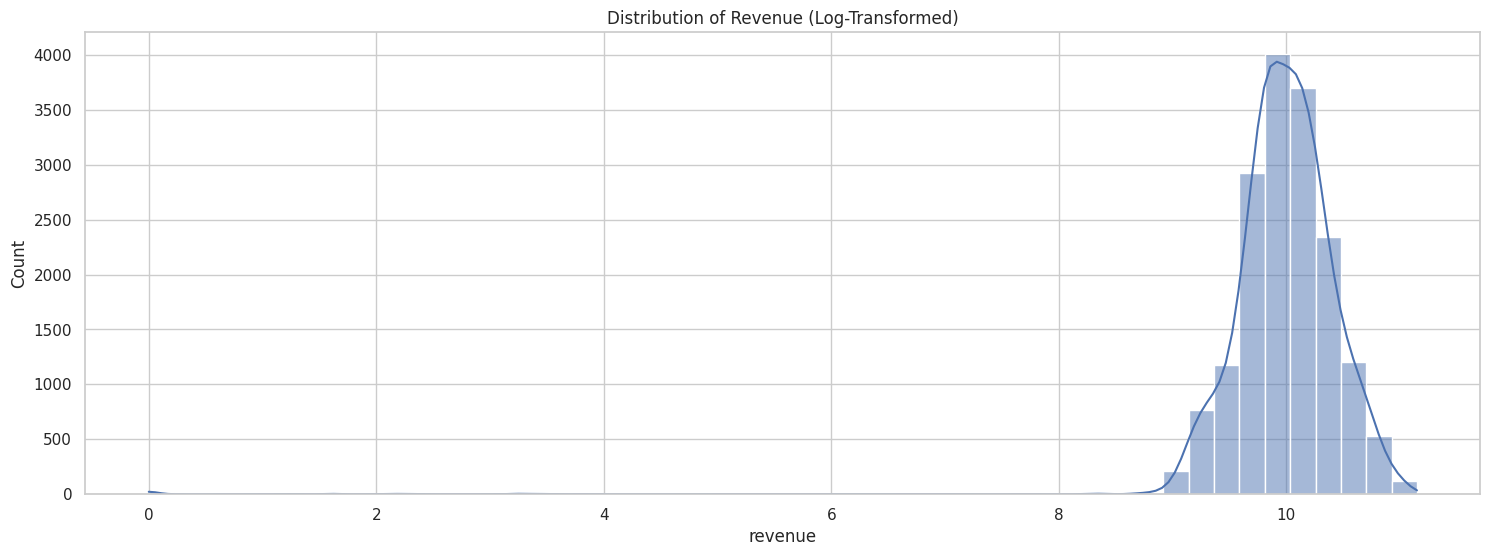

In [ ]:
# Let's visualize the revenue distribution
sns.histplot(df['revenue'], kde=True, bins=50)
plt.title('Distribution of Revenue (Original)')
plt.show()

# Now apply log1p and visualize again
sns.histplot(np.log1p(df['revenue']), kde=True, bins=50)
plt.title('Distribution of Revenue (Log-Transformed)')
plt.show()

In [ ]:
def create_features(data):
    """
    Creates time series features from a datetime index.
    """
    # Make a copy to avoid modifying the original dataframe
    new_df = data.copy()

    # --- 1. Date-based Features ---
    # These help the model learn seasonal patterns
    new_df['date'] = pd.to_datetime(new_df['date'])
    new_df['day_of_week'] = new_df['date'].dt.dayofweek  # Monday=0, Sunday=6
    new_df['day_of_month'] = new_df['date'].dt.day
    new_df['week_of_year'] = new_df['date'].dt.isocalendar().week.astype(int)
    new_df['month'] = new_df['date'].dt.month
    new_df['year'] = new_df['date'].dt.year
    new_df['is_weekend'] = (new_df['day_of_week'] >= 5).astype(int) # 1 for weekend, 0 for weekday

    # --- 2. Lag Features ---
    # These are the most powerful features. They tell the model what the revenue was in the recent past.
    # We must create lags based on our forecast horizon, H. The smallest lag must be >= H.
    # Let's assume H was 28 (replace with the actual H you found if different)
    h_forecast = H
    lags = [h_forecast, h_forecast + 1, h_forecast + 7, h_forecast + 14, h_forecast + 28]

    # Sort data to ensure lags are correct
    new_df = new_df.sort_values(['store_id', 'date'])

    for lag in lags:
        new_df[f'revenue_lag_{lag}'] = new_df.groupby('store_id')['revenue'].shift(lag)

    # --- 3. Rolling Window Features ---
    # These capture recent trends and momentum.
    # We use a window that starts after the lag period.
    window_sizes = [7, 14, 28]
    for window in window_sizes:
        # The shift of h_forecast is crucial to prevent data leakage
        rolling_series = new_df.groupby('store_id')['revenue'].shift(h_forecast).rolling(window)
        new_df[f'revenue_roll_mean_{window}'] = rolling_series.mean()
        new_df[f'revenue_roll_std_{window}'] = rolling_series.std()

    # --- 4. Event Features ---
    # Convert text-based events into a format the model can use.
    # We will use one-hot encoding later, but for now we can make it a categorical type.
    new_df['event'] = new_df['event'].astype('category')

    # Convert store_id to category as well, so the model treats it as a label, not a number.
    new_df['store_id'] = new_df['store_id'].astype('category')

    return new_df

In [ ]:
# --- Apply the feature engineering function ---
# First, apply log-transform to the revenue
df['revenue'] = np.log1p(df['revenue'])

# Now generate all features on the full transformed dataset
df_featured = create_features(df)

# IMPORTANT: Drop rows with NaN values created by lags and rolling windows
df_featured.dropna(inplace=True)

# --- Re-create train and validation sets from the FEATURED data ---
last_train_date_featured = df_featured['date'].max() - pd.to_timedelta(H, unit='D')
validation_start_date_featured = last_train_date_featured + pd.to_timedelta(1, unit='D')

train_final = df_featured[df_featured['date'] <= last_train_date_featured]
val_final = df_featured[df_featured['date'] >= validation_start_date_featured]

# --- Define our features (X) and target (y) ---
# The target is the original 'revenue' column (which is now log-transformed)
TARGET = 'revenue'

# Features are all columns except the target and identifiers that leak info
# We exclude 'store_name' and the original 'date' column
FEATURES = [col for col in train_final.columns if col not in [TARGET, 'store_name', 'date', 'weekday']]
# 'weekday' is excluded because we already have 'day_of_week' numeric feature

X_train = train_final[FEATURES]
y_train = train_final[TARGET]

X_val = val_final[FEATURES]
y_val = val_final[TARGET]

# Check the shapes to ensure everything is correct
print("Training data shape (X, y):", X_train.shape, y_train.shape)
print("Validation data shape (X, y):", X_val.shape, y_val.shape)
print("\nHere are a few of the features we created:")
print(X_train.head())

Training data shape (X, y): (14940, 19) (14940,)
Validation data shape (X, y): (920, 19) (920,)

Here are a few of the features we created:
    store_id           event  day_of_week  day_of_month  week_of_year  month  \
120        1               0            6            29            21      5   
121        1     MemorialDay            0            30            22      5   
122        1  NBAFinalsStart            1            31            22      5   
123        1               0            2             1            22      6   
124        1               0            3             2            22      6   

     year  is_weekend  revenue_lag_92  revenue_lag_93  revenue_lag_99  \
120  2011           1       10.109275        9.840810       10.241951   
121  2011           0       10.121414       10.109275       10.188683   
122  2011           0        9.641020       10.121414       10.004199   
123  2011           0        9.784956        9.641020        9.673399   
124  2011     

# 4. Modeling with LightGBM

In [ ]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

# --- 1. Identify Categorical Features ---
# It's important to tell LightGBM which features are categorical.
# This allows it to handle them more efficiently than treating them as numbers.
categorical_features = ['store_id', 'event', 'day_of_week', 'month', 'year', 'is_weekend']

# --- 2. Initialize and Train the Model ---
# We'll start with a solid set of default parameters.
lgbm = lgb.LGBMRegressor(
    objective='rmse',  # Our evaluation metric
    metric='rmse',
    n_estimators=1000, # We'll train up to 1000 trees, but...
    learning_rate=0.05,
    random_state=42,
    n_jobs=-1,         # Use all available CPU cores
    force_col_wise=True
)

print("Training LightGBM model...")
lgbm.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='rmse',
    callbacks=[lgb.early_stopping(10, verbose=True)], # ...early stopping will find the best number for us!
    categorical_feature=categorical_features
)

# --- 3. Make Predictions on the Validation Set ---
val_predictions_log = lgbm.predict(hX_val)

# --- 4. Inverse Transform the Predictions ---
# This is a critical step! Our model predicted log(revenue+1).
# We need to convert it back to actual revenue.
val_predictions = np.expm1(val_predictions_log)

# Also inverse transform the true values for comparison
y_val_original = np.expm1(y_val)

# --- 5. Evaluate the Model ---
lgbm_rmse = np.sqrt(mean_squared_error(y_val_original, val_predictions))

print(f"\nSeasonal Naive Baseline RMSE: 4324.50")
print(f"LightGBM Model RMSE: {lgbm_rmse:.2f}")

improvement = (4324.50 - lgbm_rmse) / 4324.50 * 100
print(f"\nImprovement over baseline: {improvement:.2f}%")

if lgbm_rmse < 4324.50:
    print("Excellent! The LightGBM model significantly outperformed our baseline.")
else:
    print("The LightGBM model did not beat the baseline. We may need to review features or hyperparameters.")

Training LightGBM model...
[LightGBM] [Info] Total Bins 2965
[LightGBM] [Info] Number of data points in the train set: 14940, number of used features: 19
[LightGBM] [Info] Start training from score 9.990718
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[230]	valid_0's rmse: 0.125632

Seasonal Naive Baseline RMSE: 4324.50
LightGBM Model RMSE: 3803.04

Improvement over baseline: 12.06%
Excellent! The LightGBM model significantly outperformed our baseline.


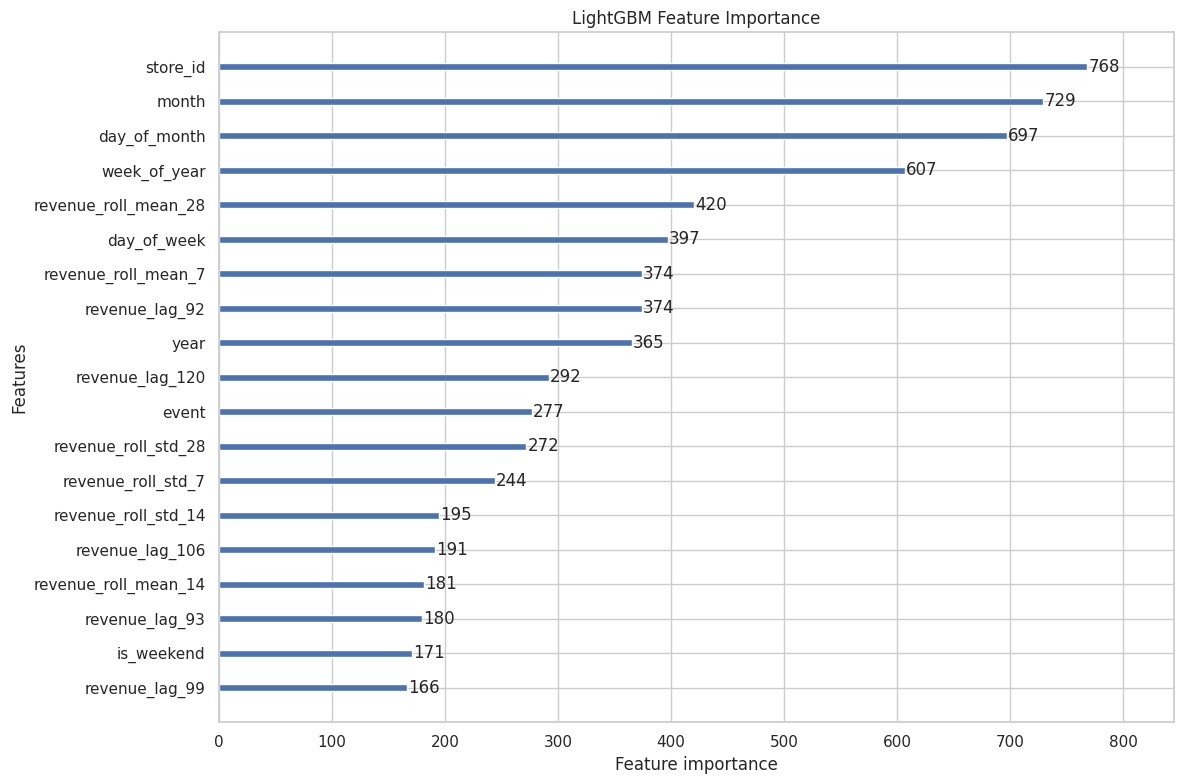

In [ ]:
# Plot feature importance
lgb.plot_importance(lgbm, figsize=(12, 8), max_num_features=20)
plt.title('LightGBM Feature Importance')
plt.tight_layout()
plt.show()

### 5. Hyperparameter Tuning

Hyperparameter Tuning with Optuna

In [ ]:


# --- 1. Define the Objective Function for Optuna ---
def objective(trial):
    # --- Define the search space for hyperparameters ---
    # Optuna will pick values from these ranges.
    params = {
        'objective': 'rmse',
        'metric': 'rmse',
        'n_estimators': 1000, # We still use early stopping
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'max_depth': trial.suggest_int('max_depth', -1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'random_state': 42,
        'n_jobs': -1,
    }

    # --- Train the model with the suggested params ---
    model = lgb.LGBMRegressor(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='rmse',
        callbacks=[lgb.early_stopping(10, verbose=False)], # Verbose=False keeps the output clean
        categorical_feature=categorical_features # Re-use our list of categoricals
    )

    # --- Make predictions and calculate RMSE ---
    preds_log = model.predict(X_val)
    preds = np.expm1(preds_log)
    rmse = np.sqrt(mean_squared_error(np.expm1(y_val), preds))

    return rmse

# --- 2. Create and Run the Optuna Study ---
# We want to 'minimize' the RMSE.
study = optuna.create_study(direction='minimize')
# We'll run 50 trials. For a real competition, you might do 100-200.
study.optimize(objective, n_trials=50)


# --- 3. Print the Best Results ---
print("\nOptuna Study Finished!")
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
best_trial = study.best_trial

print("  Value (RMSE): ", best_trial.value)
print("  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 7.6 MB/s eta 0:00:00


[I 2025-12-29 11:36:29,221] A new study created in memory with name: no-name-4911ab5a-f5df-4359-b965-23d7cb6426f3


[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003654 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2965
[LightGBM] [Info] Number of data points in the train set: 14940, number of used features: 19
[LightGBM] [Info] Start training from score 9.990718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-12-29 11:36:29,682] Trial 0 finished with value: 5191.889007534563 and parameters: {'learning_rate': 0.023685845003526065, 'num_leaves': 70, 'max_depth': 1, 'subsample': 0.7461305662276727, 'colsample_bytree': 0.7067437996703619, 'reg_alpha': 0.9557800499017624, 'reg_lambda': 0.5893469194130253}. Best is trial 0 with value: 5191.889007534563.
[I 2025-12-29 11:36:29,836] Trial 1 finished with value: 4601.840323808636 and parameters: {'learning_rate': 0.22825105193686207, 'num_leaves': 150, 'max_depth': 1, 'subsample': 0.7476341711130108, 'colsample_bytree': 0.929769857745606, 'reg_alpha': 0.6074563013745965, 'reg_lambda': 0.12051431190815654}. Best is trial 1 with value: 4601.840323808636.


[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003733 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2965
[LightGBM] [Info] Number of data points in the train set: 14940, number of used features: 19
[LightGBM] [Info] Start training from score 9.990718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-12-29 11:36:30,027] Trial 2 finished with value: 4279.989559999973 and parameters: {'learning_rate': 0.11147162261237599, 'num_leaves': 96, 'max_depth': 2, 'subsample': 0.6840615115510472, 'colsample_bytree': 0.8257618132440532, 'reg_alpha': 0.09735843678141509, 'reg_lambda': 0.5532910440476642}. Best is trial 2 with value: 4279.989559999973.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-29 11:36:30,909] Trial 3 finished with value: 3771.5941155326454 and parameters: {'learning_rate': 0.10818007874472149, 'num_leaves': 120, 'max_depth': 9, 'subsample': 0.7810993848079932, 'colsample_bytree': 0.9080812730182746, 'reg_alpha': 0.7992079035432008, 'reg_lambda': 0.6658635044765611}. Best is trial 3 with value: 3771.5941155326454.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-29 11:36:31,212] Trial 4 finished with value: 4020.1902469056863 and parameters: {'learning_rate': 0.09968689785358564, 'num_leaves': 162, 'max_depth': 3, 'subsample': 0.6557255464013414, 'colsample_bytree': 0.7315837785248132, 'reg_alpha': 0.4831725531336363, 'reg_lambda': 0.045570017326572954}. Best is trial 3 with value: 3771.5941155326454.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to c

[I 2025-12-29 11:36:31,995] Trial 5 finished with value: 3772.056405352798 and parameters: {'learning_rate': 0.11804516017885175, 'num_leaves': 206, 'max_depth': 10, 'subsample': 0.8702433722743865, 'colsample_bytree': 0.9120853706880421, 'reg_alpha': 0.43233559675374866, 'reg_lambda': 0.6959095783262056}. Best is trial 3 with value: 3771.5941155326454.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-29 11:36:32,316] Trial 6 finished with value: 3844.9043126195616 and parameters: {'learning_rate': 0.18380602817729802, 'num_leaves': 166, 'max_depth': 4, 'subsample': 0.7200842570553709, 'colsample_bytree': 0.7889889617888279, 'reg_alpha': 0.7488223198159457, 'reg_lambda': 0.21610021524884282}. Best is trial 3 with value: 3771.5941155326454.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-29 11:36:32,582] Trial 7 finished with value: 4667.71440744467 and parameters: {'learning_rate': 0.20909715034951418, 'num_leaves': 223, 'max_depth': 1, 'subsample': 0.9655840033062518, 'colsample_bytree': 0.796987200274593, 'reg_alpha': 0.09352639332873791, 'reg_lambda': 0.8570412228151876}. Best is trial 3 with value: 3771.5941155326454.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-29 11:36:33,157] Trial 8 finished with value: 4038.0127508712626 and parameters: {'learning_rate': 0.2506775223847261, 'num_leaves': 63, 'max_depth': 2, 'subsample': 0.8643470649002976, 'colsample_bytree': 0.7320444824685506, 'reg_alpha': 0.32825238650034605, 'reg_lambda': 0.9487601163078107}. Best is trial 3 with value: 3771.5941155326454.


[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2965
[LightGBM] [Info] Number of data points in the train set: 14940, number of used features: 19
[LightGBM] [Info] Start training from score 9.990718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-12-29 11:36:37,691] Trial 9 finished with value: 3825.2695602315134 and parameters: {'learning_rate': 0.08158922015445769, 'num_leaves': 175, 'max_depth': 5, 'subsample': 0.8312109779055937, 'colsample_bytree': 0.6547358650025098, 'reg_alpha': 0.3718026574990897, 'reg_lambda': 0.7272956567114923}. Best is trial 3 with value: 3771.5941155326454.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-29 11:36:39,360] Trial 10 finished with value: 4202.003255545798 and parameters: {'learning_rate': 0.037850901157785125, 'num_leaves': 297, 'max_depth': 10, 'subsample': 0.9728871761740726, 'colsample_bytree': 0.9787974578288863, 'reg_alpha': 0.9578180908740381, 'reg_lambda': 0.35390548491390206}. Best is trial 3 with value: 3771.5941155326454.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2965
[LightGBM] [Info] Number of data points in the train set: 14940, number of used features: 19
[LightGBM] [Info] Start training from score 9.990718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-12-29 11:36:40,388] Trial 11 finished with value: 3684.7016859719934 and parameters: {'learning_rate': 0.15012500554584773, 'num_leaves': 237, 'max_depth': 10, 'subsample': 0.8891107954562314, 'colsample_bytree': 0.8944472512841326, 'reg_alpha': 0.7458202831073543, 'reg_lambda': 0.716770470136788}. Best is trial 11 with value: 3684.7016859719934.


[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003819 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2965
[LightGBM] [Info] Number of data points in the train set: 14940, number of used features: 19
[LightGBM] [Info] Start training from score 9.990718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-12-29 11:36:40,883] Trial 12 finished with value: 3801.171664703046 and parameters: {'learning_rate': 0.16326595710527028, 'num_leaves': 274, 'max_depth': 7, 'subsample': 0.6020191588521102, 'colsample_bytree': 0.8734259936745409, 'reg_alpha': 0.7311028892503718, 'reg_lambda': 0.7512258099057469}. Best is trial 11 with value: 3684.7016859719934.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003742 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2965
[LightGBM] [Info] Number of data points in the train set: 14940, number of used features: 19
[LightGBM] [Info] Start training from score 9.990718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-12-29 11:36:41,291] Trial 13 finished with value: 3860.512801128431 and parameters: {'learning_rate': 0.2948890659384867, 'num_leaves': 115, 'max_depth': 8, 'subsample': 0.9143692927999625, 'colsample_bytree': 0.9984360134142405, 'reg_alpha': 0.766619758015908, 'reg_lambda': 0.425153629020508}. Best is trial 11 with value: 3684.7016859719934.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003652 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2965
[LightGBM] [Info] Number of data points in the train set: 14940, number of used features: 19
[LightGBM] [Info] Start training from score 9.990718


[I 2025-12-29 11:36:41,693] Trial 14 finished with value: 3753.0504624411687 and parameters: {'learning_rate': 0.14988468163384616, 'num_leaves': 25, 'max_depth': 8, 'subsample': 0.795410622479297, 'colsample_bytree': 0.8653165364523864, 'reg_alpha': 0.8401670419057309, 'reg_lambda': 0.9904400822026941}. Best is trial 11 with value: 3684.7016859719934.


[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003875 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2965
[LightGBM] [Info] Number of data points in the train set: 14940, number of used features: 19
[LightGBM] [Info] Start training from score 9.990718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-12-29 11:36:42,043] Trial 15 finished with value: 3981.130696678175 and parameters: {'learning_rate': 0.14473110754113025, 'num_leaves': 24, 'max_depth': 6, 'subsample': 0.9140336237037913, 'colsample_bytree': 0.8573479681687441, 'reg_alpha': 0.6062077825170746, 'reg_lambda': 0.9899585989012704}. Best is trial 11 with value: 3684.7016859719934.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003911 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2965
[LightGBM] [Info] Number of data points in the train set: 14940, number of used features: 19
[LightGBM] [Info] Start training from score 9.990718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-12-29 11:36:44,354] Trial 16 finished with value: 3834.2871634801936 and parameters: {'learning_rate': 0.06446512166929172, 'num_leaves': 247, 'max_depth': -1, 'subsample': 0.7976839504717805, 'colsample_bytree': 0.9462439387082703, 'reg_alpha': 0.6208218123842427, 'reg_lambda': 0.8602444457686451}. Best is trial 11 with value: 3684.7016859719934.


[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2965
[LightGBM] [Info] Number of data points in the train set: 14940, number of used features: 19
[LightGBM] [Info] Start training from score 9.990718


[I 2025-12-29 11:36:44,801] Trial 17 finished with value: 3819.2168844152193 and parameters: {'learning_rate': 0.15118044220431232, 'num_leaves': 21, 'max_depth': 8, 'subsample': 0.8427103511900268, 'colsample_bytree': 0.8617826542994133, 'reg_alpha': 0.8628245510840691, 'reg_lambda': 0.8445159866622034}. Best is trial 11 with value: 3684.7016859719934.


[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001104 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2965
[LightGBM] [Info] Number of data points in the train set: 14940, number of used features: 19
[LightGBM] [Info] Start training from score 9.990718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Light

[I 2025-12-29 11:36:45,440] Trial 18 finished with value: 4030.266453271775 and parameters: {'learning_rate': 0.1874337706750277, 'num_leaves': 199, 'max_depth': 7, 'subsample': 0.9321556716822869, 'colsample_bytree': 0.6010111682428574, 'reg_alpha': 0.8778105455532359, 'reg_lambda': 0.43968811534908464}. Best is trial 11 with value: 3684.7016859719934.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-29 11:36:45,788] Trial 19 finished with value: 4120.494937702202 and parameters: {'learning_rate': 0.13926523941745123, 'num_leaves': 254, 'max_depth': 9, 'subsample': 0.8834253056937926, 'colsample_bytree': 0.7749328155936398, 'reg_alpha': 0.6624300168778177, 'reg_lambda': 0.9982079951142855}. Best is trial 11 with value: 3684.7016859719934.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-29 11:36:46,125] Trial 20 finished with value: 3909.3482364479473 and parameters: {'learning_rate': 0.27099655928206745, 'num_leaves': 238, 'max_depth': 6, 'subsample': 0.9992157053883408, 'colsample_bytree': 0.8299321385554507, 'reg_alpha': 0.25278257604981397, 'reg_lambda': 0.8102023902367632}. Best is trial 11 with value: 3684.7016859719934.


[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004370 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2965
[LightGBM] [Info] Number of data points in the train set: 14940, number of used features: 19
[LightGBM] [Info] Start training from score 9.990718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-12-29 11:36:46,882] Trial 21 finished with value: 3872.1828093587924 and parameters: {'learning_rate': 0.06232294784776812, 'num_leaves': 125, 'max_depth': 9, 'subsample': 0.7911189997407024, 'colsample_bytree': 0.8992799222142315, 'reg_alpha': 0.8447981539108821, 'reg_lambda': 0.6485149142021497}. Best is trial 11 with value: 3684.7016859719934.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003765 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2965
[LightGBM] [Info] Number of data points in the train set: 14940, number of used features: 19
[LightGBM] [Info] Start training from score 9.990718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-12-29 11:36:47,927] Trial 22 finished with value: 3753.3721758460906 and parameters: {'learning_rate': 0.122953318279025, 'num_leaves': 59, 'max_depth': 10, 'subsample': 0.7743626590950823, 'colsample_bytree': 0.954375611669264, 'reg_alpha': 0.8104195198506222, 'reg_lambda': 0.61343748894197}. Best is trial 11 with value: 3684.7016859719934.


[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021736 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2965
[LightGBM] [Info] Number of data points in the train set: 14940, number of used features: 19
[LightGBM] [Info] Start training from score 9.990718


[I 2025-12-29 11:36:50,833] Trial 23 finished with value: 3957.3352172416503 and parameters: {'learning_rate': 0.18164722130846353, 'num_leaves': 56, 'max_depth': 10, 'subsample': 0.8375214302975127, 'colsample_bytree': 0.9575431790006026, 'reg_alpha': 0.972675270894864, 'reg_lambda': 0.5224200651131956}. Best is trial 11 with value: 3684.7016859719934.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023299 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2965
[LightGBM] [Info] Number of data points in the train set: 14940, number of used features: 19
[LightGBM] [Info] Start training from score 9.990718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-12-29 11:36:52,511] Trial 24 finished with value: 3806.5757952057206 and parameters: {'learning_rate': 0.1338813928754762, 'num_leaves': 48, 'max_depth': 8, 'subsample': 0.7521053596523314, 'colsample_bytree': 0.8803127430771138, 'reg_alpha': 0.5292814847688028, 'reg_lambda': 0.3083704134498005}. Best is trial 11 with value: 3684.7016859719934.


[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003707 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2965
[LightGBM] [Info] Number of data points in the train set: 14940, number of used features: 19
[LightGBM] [Info] Start training from score 9.990718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-12-29 11:36:53,209] Trial 25 finished with value: 3739.185644360822 and parameters: {'learning_rate': 0.16509468250054202, 'num_leaves': 89, 'max_depth': 10, 'subsample': 0.8156775768025524, 'colsample_bytree': 0.9679776578315158, 'reg_alpha': 0.7015093658927979, 'reg_lambda': 0.9256185000356619}. Best is trial 11 with value: 3684.7016859719934.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003713 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2965
[LightGBM] [Info] Number of data points in the train set: 14940, number of used features: 19
[LightGBM] [Info] Start training from score 9.990718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-12-29 11:36:55,494] Trial 26 finished with value: 3704.63475344235 and parameters: {'learning_rate': 0.21249525201181174, 'num_leaves': 89, 'max_depth': 9, 'subsample': 0.8234133465288777, 'colsample_bytree': 0.8318314597866632, 'reg_alpha': 0.7080472190574951, 'reg_lambda': 0.933867712948429}. Best is trial 11 with value: 3684.7016859719934.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003894 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2965
[LightGBM] [Info] Number of data points in the train set: 14940, number of used features: 19
[LightGBM] [Info] Start training from score 9.990718


[I 2025-12-29 11:36:55,873] Trial 27 finished with value: 3860.7508981765086 and parameters: {'learning_rate': 0.21268027468275502, 'num_leaves': 87, 'max_depth': 9, 'subsample': 0.8194588682850267, 'colsample_bytree': 0.8280846574523067, 'reg_alpha': 0.6960713507176797, 'reg_lambda': 0.9054314225815216}. Best is trial 11 with value: 3684.7016859719934.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003719 seconds.
You can 

[I 2025-12-29 11:36:56,089] Trial 28 finished with value: 4135.035320577409 and parameters: {'learning_rate': 0.2394834139933635, 'num_leaves': 139, 'max_depth': 7, 'subsample': 0.892806021586619, 'colsample_bytree': 0.9792502385965512, 'reg_alpha': 0.5943025476182993, 'reg_lambda': 0.7974965166454326}. Best is trial 11 with value: 3684.7016859719934.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-29 11:36:56,818] Trial 29 finished with value: 3673.2842245966854 and parameters: {'learning_rate': 0.1724357671700276, 'num_leaves': 88, 'max_depth': 10, 'subsample': 0.7137083979601853, 'colsample_bytree': 0.7609263310681047, 'reg_alpha': 0.5245002996862103, 'reg_lambda': 0.9202490546121787}. Best is trial 29 with value: 3673.2842245966854.


[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003612 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2965
[LightGBM] [Info] Number of data points in the train set: 14940, number of used features: 19
[LightGBM] [Info] Start training from score 9.990718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-12-29 11:36:57,199] Trial 30 finished with value: 3746.4657948096274 and parameters: {'learning_rate': 0.20890136562163314, 'num_leaves': 183, 'max_depth': 6, 'subsample': 0.7171762126456026, 'colsample_bytree': 0.7491467009485551, 'reg_alpha': 0.5075071096901322, 'reg_lambda': 0.7760000821485097}. Best is trial 29 with value: 3673.2842245966854.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-29 11:36:57,926] Trial 31 finished with value: 3671.816468772252 and parameters: {'learning_rate': 0.16345373407073038, 'num_leaves': 92, 'max_depth': 10, 'subsample': 0.8572466932111338, 'colsample_bytree': 0.6907196622992916, 'reg_alpha': 0.6958778511991406, 'reg_lambda': 0.9137036301263631}. Best is trial 31 with value: 3671.816468772252.


[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005485 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2965
[LightGBM] [Info] Number of data points in the train set: 14940, number of used features: 19
[LightGBM] [Info] Start training from score 9.990718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-12-29 11:36:58,708] Trial 32 finished with value: 3767.7821249288886 and parameters: {'learning_rate': 0.1782539209932106, 'num_leaves': 99, 'max_depth': 9, 'subsample': 0.8559092148993497, 'colsample_bytree': 0.6694823066508951, 'reg_alpha': 0.5626762157413164, 'reg_lambda': 0.9052957455094544}. Best is trial 31 with value: 3671.816468772252.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004891 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2965
[LightGBM] [Info] Number of data points in the train set: 14940, number of used features: 19
[LightGBM] [Info] Start training from score 9.990718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-12-29 11:36:59,471] Trial 33 finished with value: 3661.1837907290055 and parameters: {'learning_rate': 0.22288445822047248, 'num_leaves': 80, 'max_depth': 10, 'subsample': 0.6674956269509389, 'colsample_bytree': 0.692369543735946, 'reg_alpha': 0.6785403352555969, 'reg_lambda': 0.8863477532118569}. Best is trial 33 with value: 3661.1837907290055.


[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2965
[LightGBM] [Info] Number of data points in the train set: 14940, number of used features: 19
[LightGBM] [Info] Start training from score 9.990718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-12-29 11:37:00,031] Trial 34 finished with value: 3814.8225287745036 and parameters: {'learning_rate': 0.19832509471775725, 'num_leaves': 138, 'max_depth': 10, 'subsample': 0.6535044683554663, 'colsample_bytree': 0.6854633725478237, 'reg_alpha': 0.6608791795265405, 'reg_lambda': 0.861360545617661}. Best is trial 33 with value: 3661.1837907290055.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2965
[LightGBM] [Info] Number of data points in the train set: 14940, number of used features: 19
[LightGBM] [Info] Start training from score 9.990718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-12-29 11:37:00,408] Trial 35 finished with value: 3788.885623878079 and parameters: {'learning_rate': 0.22513445038839802, 'num_leaves': 76, 'max_depth': 8, 'subsample': 0.6789200712377372, 'colsample_bytree': 0.7166738943072858, 'reg_alpha': 0.39529995284488106, 'reg_lambda': 0.717119942292858}. Best is trial 33 with value: 3661.1837907290055.


[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003789 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2965
[LightGBM] [Info] Number of data points in the train set: 14940, number of used features: 19
[LightGBM] [Info] Start training from score 9.990718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-12-29 11:37:00,949] Trial 36 finished with value: 3744.8355589034372 and parameters: {'learning_rate': 0.25099274359746526, 'num_leaves': 113, 'max_depth': 10, 'subsample': 0.6116788272808865, 'colsample_bytree': 0.6290103710708558, 'reg_alpha': 0.9069873961710195, 'reg_lambda': 0.5873176382849769}. Best is trial 33 with value: 3661.1837907290055.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003715 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2965
[LightGBM] [Info] Number of data points in the train set: 14940, number of used features: 19
[LightGBM] [Info] Start training from score 9.990718


[I 2025-12-29 11:37:01,631] Trial 37 finished with value: 3737.825457224214 and parameters: {'learning_rate': 0.09197676111367731, 'num_leaves': 40, 'max_depth': -1, 'subsample': 0.6341019096029639, 'colsample_bytree': 0.7596854990860022, 'reg_alpha': 0.4826354446381498, 'reg_lambda': 0.8247259389147328}. Best is trial 33 with value: 3661.1837907290055.


[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2965
[LightGBM] [Info] Number of data points in the train set: 14940, number of used features: 19
[LightGBM] [Info] Start training from score 9.990718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-12-29 11:37:02,228] Trial 38 finished with value: 3886.625981335641 and parameters: {'learning_rate': 0.16426992651535313, 'num_leaves': 149, 'max_depth': 9, 'subsample': 0.7098750670405677, 'colsample_bytree': 0.7008303468689404, 'reg_alpha': 0.19219661452503434, 'reg_lambda': 0.6801074920502854}. Best is trial 33 with value: 3661.1837907290055.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-29 11:37:03,318] Trial 39 finished with value: 3723.763150318435 and parameters: {'learning_rate': 0.12441732855183289, 'num_leaves': 72, 'max_depth': 10, 'subsample': 0.6861694625504446, 'colsample_bytree': 0.6529987791485917, 'reg_alpha': 0.5554466062329334, 'reg_lambda': 0.766718629816939}. Best is trial 33 with value: 3661.1837907290055.


[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039338 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2965
[LightGBM] [Info] Number of data points in the train set: 14940, number of used features: 19
[LightGBM] [Info] Start training from score 9.990718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Light

[I 2025-12-29 11:37:04,812] Trial 40 finished with value: 4075.0681318490238 and parameters: {'learning_rate': 0.1956811387469917, 'num_leaves': 111, 'max_depth': 3, 'subsample': 0.7467572305214875, 'colsample_bytree': 0.7335482364578216, 'reg_alpha': 0.7643576537128154, 'reg_lambda': 0.8715332177108329}. Best is trial 33 with value: 3661.1837907290055.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036056 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2965
[LightGBM] [Info] Number of data points in the train set: 14940, number of used features: 19
[LightGBM] [Info] Start training from score 9.990718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Light

[I 2025-12-29 11:37:06,336] Trial 41 finished with value: 3877.7677854841113 and parameters: {'learning_rate': 0.1743081311459281, 'num_leaves': 86, 'max_depth': 9, 'subsample': 0.8953350738964391, 'colsample_bytree': 0.8104995718878808, 'reg_alpha': 0.6678754115088942, 'reg_lambda': 0.9277411733805822}. Best is trial 33 with value: 3661.1837907290055.


[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2965
[LightGBM] [Info] Number of data points in the train set: 14940, number of used features: 19
[LightGBM] [Info] Start training from score 9.990718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-12-29 11:37:07,640] Trial 42 finished with value: 3841.450704868457 and parameters: {'learning_rate': 0.22275152538089138, 'num_leaves': 103, 'max_depth': 9, 'subsample': 0.7616260808826893, 'colsample_bytree': 0.7045636865351848, 'reg_alpha': 0.7237603018441756, 'reg_lambda': 0.9295581911418817}. Best is trial 33 with value: 3661.1837907290055.


[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003737 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2965
[LightGBM] [Info] Number of data points in the train set: 14940, number of used features: 19
[LightGBM] [Info] Start training from score 9.990718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-12-29 11:37:08,756] Trial 43 finished with value: 3679.1265504290905 and parameters: {'learning_rate': 0.19988756552627568, 'num_leaves': 131, 'max_depth': 10, 'subsample': 0.699101510444629, 'colsample_bytree': 0.923312921269437, 'reg_alpha': 0.7822778970466115, 'reg_lambda': 0.9635572994492597}. Best is trial 33 with value: 3661.1837907290055.


[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003732 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2965
[LightGBM] [Info] Number of data points in the train set: 14940, number of used features: 19
[LightGBM] [Info] Start training from score 9.990718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-12-29 11:37:09,240] Trial 44 finished with value: 3663.3395907221893 and parameters: {'learning_rate': 0.24533607134978977, 'num_leaves': 137, 'max_depth': 10, 'subsample': 0.6961010874224279, 'colsample_bytree': 0.9269618826099537, 'reg_alpha': 0.9178428309508955, 'reg_lambda': 0.9530745188975015}. Best is trial 33 with value: 3661.1837907290055.


[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003767 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2965
[LightGBM] [Info] Number of data points in the train set: 14940, number of used features: 19
[LightGBM] [Info] Start training from score 9.990718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-12-29 11:37:09,740] Trial 45 finished with value: 3903.904670625373 and parameters: {'learning_rate': 0.2741076208740916, 'num_leaves': 126, 'max_depth': 10, 'subsample': 0.6892065944954918, 'colsample_bytree': 0.912011835955023, 'reg_alpha': 0.9361182821307727, 'reg_lambda': 0.14157910405777518}. Best is trial 33 with value: 3661.1837907290055.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003660 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2965
[LightGBM] [Info] Number of data points in the train set: 14940, number of used features: 19
[LightGBM] [Info] Start training from score 9.990718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-12-29 11:37:10,382] Trial 46 finished with value: 3517.948318771445 and parameters: {'learning_rate': 0.23897766007300414, 'num_leaves': 155, 'max_depth': 8, 'subsample': 0.663572966193411, 'colsample_bytree': 0.6824293044038157, 'reg_alpha': 0.8076904452375828, 'reg_lambda': 0.9620865284235692}. Best is trial 46 with value: 3517.948318771445.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2965
[LightGBM] [Info] Number of data points in the train set: 14940, number of used features: 19
[LightGBM] [Info] Start training from score 9.990718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-12-29 11:37:10,801] Trial 47 finished with value: 3911.00308607555 and parameters: {'learning_rate': 0.2447784644290557, 'num_leaves': 171, 'max_depth': 8, 'subsample': 0.6647565131462625, 'colsample_bytree': 0.6755713694358512, 'reg_alpha': 0.4514098163525664, 'reg_lambda': 0.8725000717639521}. Best is trial 46 with value: 3517.948318771445.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005916 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2965
[LightGBM] [Info] Number of data points in the train set: 14940, number of used features: 19
[LightGBM] [Info] Start training from score 9.990718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-12-29 11:37:11,267] Trial 48 finished with value: 4032.3701458202067 and parameters: {'learning_rate': 0.2606355412191841, 'num_leaves': 157, 'max_depth': 7, 'subsample': 0.7344362812780044, 'colsample_bytree': 0.6466426682088002, 'reg_alpha': 0.8134720573297125, 'reg_lambda': 0.9691533739526647}. Best is trial 46 with value: 3517.948318771445.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-29 11:37:11,524] Trial 49 finished with value: 3805.1485702323002 and parameters: {'learning_rate': 0.295544315462482, 'num_leaves': 149, 'max_depth': 5, 'subsample': 0.6345267877297429, 'colsample_bytree': 0.6911519066873044, 'reg_alpha': 0.014259944340761, 'reg_lambda': 0.8899980713704723}. Best is trial 46 with value: 3517.948318771445.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [ ]:
# --- 4. Train the Final Tuned Model ---
# Get the best hyperparameters from the study
best_params = best_trial.params
best_params['objective'] = 'rmse'
best_params['metric'] = 'rmse'
best_params['random_state'] = 42
best_params['n_estimators'] = 1000 # Use a high number, early stopping will handle it
best_params['n_jobs'] = -1


print("\nTraining final model with best parameters...")
final_model = lgb.LGBMRegressor(**best_params)
final_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='rmse',
    callbacks=[lgb.early_stopping(10, verbose=True)],
    categorical_feature=categorical_features
)

# --- Evaluate the Final Tuned Model ---
final_preds_log = final_model.predict(X_val)
final_preds = np.expm1(final_preds_log)
final_rmse = np.sqrt(mean_squared_error(y_val_original, final_preds))


print(f"Final Tuned LightGBM RMSE: {final_rmse:.2f}")



Training final model with best parameters...
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003627 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2965
[LightGBM] [Info] Number of data points in the train set: 14940, number of used features: 19
[LightGBM] [Info] Start training from score 9.990718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

# The Final Prediction Pipeline

In [ ]:
# --- 1. Retrain the final model on ALL available data ---
# This gives the model maximum information before forecasting.

# First, get the full set of features and the target
ALL_FEATURES = [col for col in df_featured.columns if col not in [TARGET, 'store_name', 'date', 'weekday']]
X_all = df_featured[ALL_FEATURES]
y_all = df_featured[TARGET]

# Use the best parameters found by Optuna
final_model_for_submission = lgb.LGBMRegressor(**best_trial.params)

print("Retraining model on all available data...")
final_model_for_submission.fit(X_all, y_all, categorical_feature=categorical_features)
print("Model retraining complete.")


Retraining model on all available data...
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006534 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2965
[LightGBM] [Info] Number of data points in the train set: 15860, number of used features: 19
[LightGBM] [Info] Start training from score 10.006302
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

In [ ]:
df['store_id'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [ ]:

# --- 2. Set up the Recursive Forecasting Loop ---
# This is where the magic happens.

# Get the last known date from our original data
last_known_date = df['date'].max()
# Get the last `N` days of data to compute future lags/rolling features.
# A safe number is the max lag or window size we used. Let's use 120 days.
history_df = df_featured.groupby('store_id').tail(120).copy()

future_predictions = []

print(f"\nStarting recursive forecast for {H} days...")
for i in range(H):
    # The date we want to predict
    predict_date = last_known_date + pd.to_timedelta(i + 1, unit='D')

    # Create a placeholder row for each store for the future date
    future_rows = []
    for store_id in df['store_id'].unique():
        future_rows.append({'date': predict_date, 'store_id': store_id})
    future_df = pd.DataFrame(future_rows)

    # Merge calendar events for the future date
    future_df = pd.merge(future_df, calendar_df, on='date', how='left')
    future_df['event'].fillna('NoEvent', inplace=True)

    # Create features for this future row using our past history
    # We combine history with the new rows to calculate lags correctly
    combined_df = pd.concat([history_df, future_df], ignore_index=True)
    featured_future = create_features(combined_df)

    # Isolate the last 10 rows which are the ones we want to predict
    predict_data = featured_future[featured_future['date'] == predict_date].copy()

    # Select the features for prediction
    X_predict = predict_data[ALL_FEATURES]

    # Predict in log scale
    preds_log = final_model_for_submission.predict(X_predict)
    # Inverse transform to original scale
    preds_revenue = np.expm1(preds_log)

    # Store the predictions
    predict_data['revenue'] = preds_revenue
    future_predictions.append(predict_data[['date', 'store_id', 'revenue']])

    # CRITICAL: Update history for the next loop iteration
    # The predicted data becomes part of the new history
    history_df = pd.concat([history_df, predict_data], ignore_index=True)

print("Recursive forecast complete.")

# Combine all predictions into a single dataframe
final_predictions_df = pd.concat(future_predictions, ignore_index=True)




Starting recursive forecast for 92 days...
Recursive forecast complete.


In [ ]:
# Get the last known date from our original data
last_known_date = df['date'].max()
# Get the last `N` days of data to compute future lags/rolling features.
# A safe number is the max lag or window size we used. Let's use 120 days.
history_df = df_featured.groupby('store_id').tail(120).copy()

future_predictions = []

# The date we want to predict
predict_date = last_known_date + pd.to_timedelta(i + 1, unit='D')

# Create a placeholder row for each store for the future date
future_rows = []
for store_id in df['store_id'].unique():
    future_rows.append({'date': predict_date, 'store_id': store_id})
future_df = pd.DataFrame(future_rows)

# Merge calendar events for the future date
future_df = pd.merge(future_df, calendar_df, on='date', how='left')
future_df['event'].fillna('NoEvent', inplace=True)

# Create features for this future row using our past history
# We combine history with the new rows to calculate lags correctly
combined_df = pd.concat([history_df, future_df], ignore_index=True)
featured_future = create_features(combined_df)
featured_future
# Isolate the last 10 rows which are the ones we want to predict
predict_data = featured_future.tail(10)
predict_data
# # Select the features for prediction
# X_predict = predict_data[ALL_FEATURES]

# # Predict in log scale
# preds_log = final_model_for_submission.predict(X_predict)
# # Inverse transform to original scale
# preds_revenue = np.expm1(preds_log)

# # Store the predictions
# predict_data['revenue'] = preds_revenue
# future_predictions.append(predict_data[['date', 'store_id', 'revenue']])

# # CRITICAL: Update history for the next loop iteration
# # The predicted data becomes part of the new history
# history_df = pd.concat([history_df, predict_data], ignore_index=True)


,store_id,store_name,date,revenue,event,weekday,day_of_week,day_of_month,week_of_year,month,...,revenue_lag_93,revenue_lag_99,revenue_lag_106,revenue_lag_120,revenue_roll_mean_7,revenue_roll_std_7,revenue_roll_mean_14,revenue_roll_std_14,revenue_roll_mean_28,revenue_roll_std_28
1191,10,Wisconsin – Badger Crossing,2015-09-22,9.769272,0,Tuesday,1,22,39,9,...,9.960888,10.089502,10.062454,NaN,9.926777,0.092590,9.984081,0.131868,NaN,NaN
1192,10,Wisconsin – Badger Crossing,2015-09-23,9.758225,0,Wednesday,2,23,39,9,...,9.904382,9.919692,9.966587,NaN,9.912177,0.101520,9.973432,0.139205,NaN,NaN
1193,10,Wisconsin – Badger Crossing,2015-09-24,9.778340,EidAlAdha,Thursday,3,24,39,9,...,9.817494,9.822966,9.868266,NaN,9.898109,0.120915,9.963162,0.152253,NaN,NaN
1194,10,Wisconsin – Badger Crossing,2015-09-25,9.974713,0,Friday,4,25,39,9,...,9.724485,9.806890,9.905055,NaN,9.875333,0.151984,9.944762,0.173849,NaN,NaN
1195,10,Wisconsin – Badger Crossing,2015-09-26,10.153878,0,Saturday,5,26,39,9,...,9.647460,10.053297,10.135784,NaN,9.840036,0.131009,9.921222,0.168215,NaN,NaN
1196,10,Wisconsin – Badger Crossing,2015-09-27,10.187106,0,Sunday,6,27,39,9,...,9.806216,10.019326,10.031770,NaN,9.828659,0.115368,9.914644,0.165336,NaN,NaN
1197,10,Wisconsin – Badger Crossing,2015-09-28,9.855795,0,Monday,0,28,40,9,...,9.939685,9.960888,10.292737,NaN,9.841081,0.134991,9.897152,0.131813,NaN,NaN
1198,10,Wisconsin – Badger Crossing,2015-09-29,9.709232,0,Tuesday,1,29,40,9,...,10.047840,9.904382,10.089502,NaN,9.827732,0.132280,9.877255,0.121136,NaN,NaN
1199,10,Wisconsin – Badger Crossing,2015-09-30,9.767281,0,Wednesday,2,30,40,9,...,9.810945,9.817494,9.919692,NaN,9.821546,0.133842,9.866862,0.123435,9.958771,0.155038
1209,10,NaN,2015-10-02,NaN,NoEvent,NaN,4,2,40,10,...,9.774187,9.724485,9.822966,10.011692,9.850103,0.130977,9.874106,0.123637,9.955653,0.154812


In [ ]:
final_predictions_df


,date,store_id,revenue
0,2015-10-01,1,31613.733695
1,2015-10-01,2,29324.859055
2,2015-10-01,3,48519.330026
3,2015-10-01,4,21623.742231
4,2015-10-01,5,23255.565311
...,...,...,...
915,2015-12-31,6,24602.660843
916,2015-12-31,7,22067.168637
917,2015-12-31,8,22151.484167
918,2015-12-31,9,28109.602364


In [ ]:
# --- 3. Format for Submission ---

# We start with our dataframe of predictions for stores 1-10
individual_store_preds = final_predictions_df.copy()
print(f"Generated predictions for {individual_store_preds['store_id'].nunique()} individual stores.")

# Group by date and sum the predictions of stores 1-10 to create the forecast for store 0
aggregate_preds = individual_store_preds.groupby('date')['revenue'].sum().reset_index()
aggregate_preds['store_id'] = 0 # Assign the correct store ID for the aggregate
print("\nCreated aggregate predictions for 'store_id = 0' by summing individual stores.")

# We now have two dataframes: one for stores 1-10, one for store 0. Let's combine them.
# Reorder columns in aggregate_preds to match individual_store_preds for concatenation
aggregate_preds = aggregate_preds[['date', 'store_id', 'revenue']]
# Append the aggregate predictions to the individual ones
all_predictions_df = pd.concat([individual_store_preds.rename(columns={'revenue':'prediction'}), aggregate_preds.rename(columns={'revenue':'prediction'})], ignore_index=True)
all_predictions_df
# Now we create the 'id' column from this complete set of predictions
all_predictions_df['id'] = all_predictions_df['store_id'].astype(str) + '_' + all_predictions_df['date'].dt.strftime('%Y%m%d')

# Merge with the sample submission to ensure correct format and order
submission_df_final = sample_submission[['id']].merge(all_predictions_df[['id', 'prediction']], on='id', how='left')

submission_df_final
# # # --- Final Sanity Check ---
# if submission_df_final['prediction'].isnull().any():
#     print("\nWARNING: There are still NaN values in the submission file! Debugging needed.")
#     # Add a check to see which IDs failed to merge
#     print("IDs that failed to find a match:")
#     print(submission_df_final[submission_df_final['prediction'].isnull()])
# else:
#     print("\nSUCCESS! All 1,012 IDs matched and predictions are filled.")

# Save the submission file
submission_df_final.to_csv( DATA_PATH+ 'submission_df.csv', index=False)

print("\nSubmission file 'submission_df.csv' created successfully!")
print("Here's a sample of the submission file:")
print(submission_df_final.head())

Generated predictions for 10 individual stores.

Created aggregate predictions for 'store_id = 0' by summing individual stores.

Submission file 'submission_df.csv' created successfully!
Here's a sample of the submission file:
           id     prediction
0  0_20151001  296926.525597
1  0_20151002  341443.983467
2  0_20151003  402287.481149
3  0_20151004  373040.571580
4  0_20151005  305967.390361


In [ ]:
aggregate_preds

,date,store_id,revenue
0,2015-09-22,0,15075.597686
1,2015-09-23,0,14770.479773
2,2015-09-24,0,14502.276584
3,2015-09-25,0,16797.637882
4,2015-09-26,0,21486.119616
...,...,...,...
96,2015-12-27,0,340578.316067
97,2015-12-28,0,233027.363194
98,2015-12-29,0,114107.289096
99,2015-12-30,0,59453.065571


#  Model Explainability with SHAP

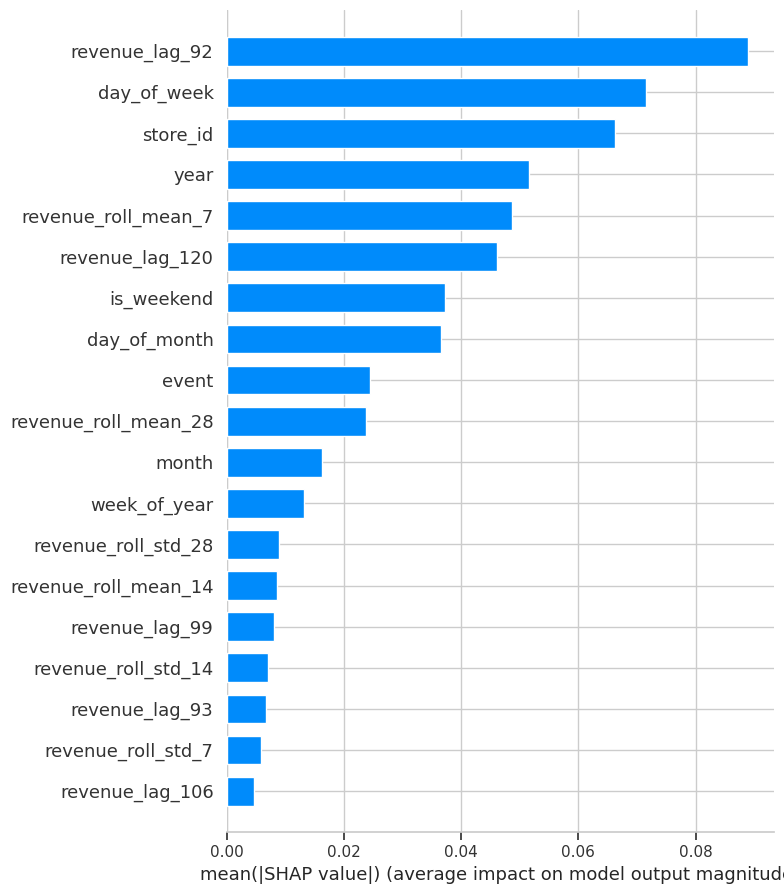

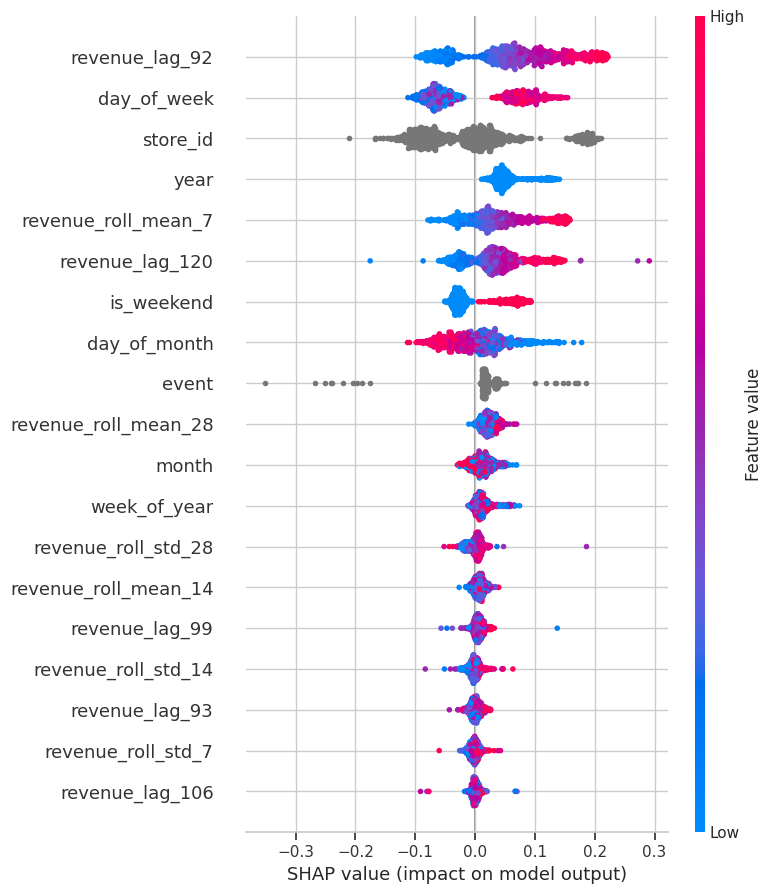

In [ ]:
# Install SHAP
!pip install shap -q

import shap

# --- Explain the final model trained on all data ---
# We use a TreeExplainer for tree-based models like LightGBM
explainer = shap.TreeExplainer(final_model_for_submission)
# Calculate SHAP values for the validation set (as a sample)
shap_values = explainer.shap_values(X_val)

# --- Create a SHAP Summary Plot ---
# This is like a super-powered feature importance plot.
# It shows not only the importance but also the direction of the effect.
shap.summary_plot(shap_values, X_val, plot_type="bar", max_display=20) # Classic bar chart
shap.summary_plot(shap_values, X_val, max_display=20) # Beeswarm plot (even better!)

### 3. Final Results records

Date: 29.12
*   **Best Validation RMSE:** '3614.85`
*   **Best Leaderboard RMSE:** `7225.3`
*   **Key Insight:** The model's feature importance plot revealed that high-level calendar features (`month`, `day_of_month`) and `store_id` were the most powerful predictors, indicating strong seasonal and store-level base patterns. Lag and rolling mean features were crucial for capturing recent dynamics.